# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Data Exploration and model for industrial crop in Italy 2006-2021
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
industrial_crop = pd.read_csv('final_data_notebooks/industrial_crop_final_2006-2021.csv',skipinitialspace=True)
industrial_crop.head()

City              Type_crop  Year  production_tonnes  total_area_ha  \
0  Agrigento  parsley in open field  2006               5.00           1.00   
1  Agrigento  parsley in open field  2006               5.00           1.00   
2  Agrigento  parsley in open field  2006               5.00           1.00   
3  Agrigento  parsley in open field  2006               5.00           1.00   
4  Agrigento  parsley in open field  2006               5.00           1.00   

   Unnamed: 0.1  Unnamed: 0    PS    TS  QV2M  ...  T2M_MIN  GWETPROF  \
0        603.00        6.00 96.87 16.70  8.33  ...     6.77      0.61   
1        603.00        6.00 96.87 16.70  8.33  ...     6.77      0.61   
2        603.00        6.00 96.87 16.70  8.33  ...     6.77      0.61   
3        603.00        6.00 96.87 16.70  8.33  ...     6.77      0.61   
4        603.00        6.00 96.87 16.70  8.33  ...     6.77      0.61   

   GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR     Type_fertilizer  \
0      0.62      39.63      21.74         1.58   calcium cyanamide   
1      0.62      39.63      21.74         1.58  nitrogen-potassium   
2      0.62      39.63      21.74         1.58         peaty-amend   
3      0.62      39.63      21.74         1.58    organic-nitrogen   
4      0.62      39.63      21.74         1.58             organic   

   Fertilizers_tonnes   lat   lon  
0                0.00 37.31 13.58  
1               27.70 37.31 13.58  
2              174.50 37.31 13.58  
3              760.50 37.31 13.58  
4             1343.70 37.31 13.58  

[5 rows x 24 columns]

## Pre-processing dataset 

In [3]:
def show_info(industrial_crop):
    print('DATASET SHAPE: ',industrial_crop.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(industrial_crop.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(industrial_crop.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(industrial_crop.isnull().sum())
show_info(industrial_crop)

DATASET SHAPE:  (65619, 24) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65619 entries, 0 to 65618
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                65619 non-null  object 
 1   Type_crop           65619 non-null  object 
 2   Year                65619 non-null  int64  
 3   production_tonnes   65619 non-null  float64
 4   total_area_ha       65619 non-null  float64
 5   Unnamed: 0.1        65619 non-null  float64
 6   Unnamed: 0          65619 non-null  float64
 7   PS                  65619 non-null  float64
 8   TS                  65619 non-null  float64
 9   QV2M                65619 non-null  float64
 10  RH2M                65619 non-null  float64
 11  WS2M                65619 non-null  float64
 12  GWETTOP             65619 non-null  float64
 13  T2M_MAX             65619 non-null  float64
 14  T

In [4]:
industrial_crop.describe()

Year  production_tonnes  total_area_ha  Unnamed: 0.1  Unnamed: 0  \
count 65619.00           65619.00       65619.00      65619.00    65619.00   
mean   2013.88            3008.72         944.91      26629.56       59.72   
std       4.63           12102.73        3519.04      16128.01       41.71   
min    2006.00               0.00           0.00          0.00        0.00   
25%    2010.00              20.00           0.00      15330.00       19.00   
50%    2014.00             135.00          16.00      26373.00       58.00   
75%    2018.00             843.00         270.00      37737.00       97.00   
max    2021.00          173978.00       49065.00      52987.00      136.00   

            PS       TS     QV2M     RH2M     WS2M  ...  T2M_MAX  T2M_MIN  \
count 65619.00 65619.00 65619.00 65619.00 65619.00  ... 65619.00 65619.00   
mean     94.03    13.66     7.47    69.78     1.99  ...    23.88     4.65   
std      19.93     3.85     1.75    14.91     0.84  ...     5.46     3.38   
min       0.00     0.00     0.00     0.00     0.00  ...     0.00    -8.68   
25%      96.54    12.50     7.19    70.67     1.48  ...    23.38     2.65   
50%      98.65    14.31     7.71    72.68     1.92  ...    24.98     4.30   
75%     100.04    16.04     8.24    74.70     2.50  ...    26.48     6.83   
max     101.70    20.32    10.60    82.11     4.70  ...    30.90    14.27   

       GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR  \
count  65619.00  65619.00   65619.00   65619.00     65619.00   
mean       0.61      0.62      50.63      19.22         2.14   
std        0.15      0.15      12.41       5.08         0.76   
min        0.00      0.00       0.00       0.00         0.00   
25%        0.58      0.59      47.62      18.07         1.71   
50%        0.64      0.65      52.93      20.66         2.14   
75%        0.69      0.70      57.64      22.19         2.55   
max        0.85      0.84      74.91      26.54         4.72   

       Fertilizers_tonnes      lat      lon  
count            65619.00 65619.00 65619.00  
mean              2275.69    43.00    11.62  
std               5052.47     5.12     2.59  
min                  0.00     0.00     0.00  
25%                 54.00    41.89    10.03  
50%                403.00    43.93    11.79  
75%               1967.00    45.41    12.91  
max              98671.60    46.14    18.17  

[8 rows x 21 columns]

## Total industrial_crop production in 2006-2021

In [5]:
industrial_crop = industrial_crop.drop(columns = ['Unnamed: 0.1','Unnamed: 0'])


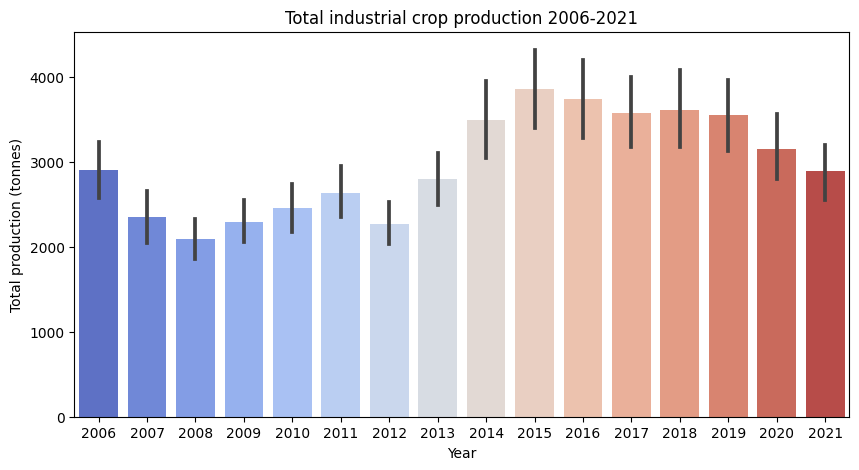

In [6]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'production_tonnes',data =industrial_crop,palette='coolwarm')
plt.title('Total industrial crop production 2006-2021')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Cereal production by Cities 

In [7]:
industrial_crop_region =industrial_crop.groupby(by =industrial_crop.City)['production_tonnes','City'].sum().reset_index().sort_values(by = 'production_tonnes', ascending = False).head(10)
industrial_crop_region

City  production_tonnes
101    Venezia        19493598.00
96     Treviso        17227482.00
98       Udine        13472628.00
83      Rovigo        13189288.00
31     Ferrara        11477500.00
63      Padova        10164494.00
104     Verona         9191046.00
50     Mantova         8849724.00
67     Perugia         8778621.00
73   Pordenone         8743066.00

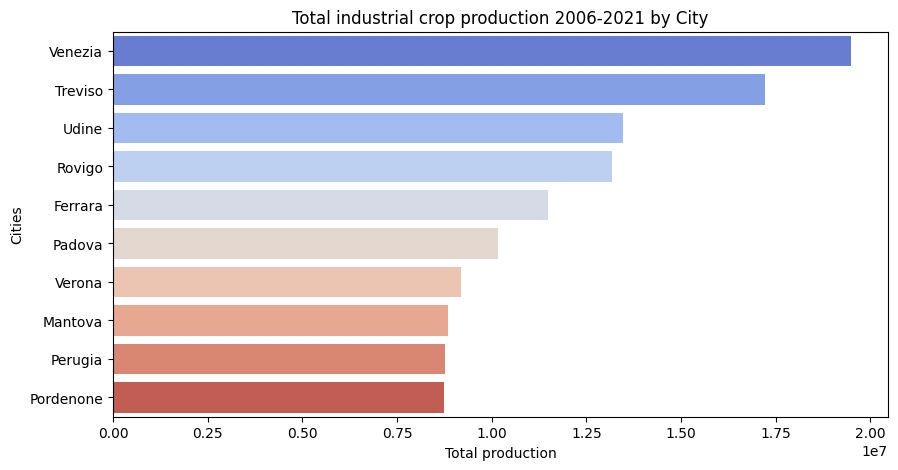

In [8]:
plt.figure(figsize= (10,5))
sns.barplot(x=industrial_crop_region['production_tonnes'],y=industrial_crop_region['City'], orient='h', palette='coolwarm');
plt.title('Total industrial crop production 2006-2021 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

##industrial_crop highest production 2006-2021

In [9]:
print(industrial_crop.Type_crop.max())
print(industrial_crop.Type_crop.value_counts())
print(industrial_crop.Type_crop.nunique())



valerian in greenhouses
sunflower                                        11629
rape                                              9901
soya beans                                        9600
sweet basil in greenhouses                        6742
parsley in open field                             6479
parsley in greenhouses                            6109
tobacco                                           3700
valerian in greenhouses                           3580
hemp                                              3280
0                                                 1299
flax                                              1280
turnip rape                                        890
groundnut                                          540
hops                                               350
sesame                                              80
other aromatic, medicinal and culinary plants       80
cotton                                              50
other textile crops                      

In [10]:
print(industrial_crop.total_area_ha.max())
print(industrial_crop.total_area_ha.min())
print(industrial_crop.total_area_ha.value_counts())
print(industrial_crop.total_area_ha.nunique())


49065.0
0.0
0.00        17960
1.00         2270
5.00         2150
2.00         1780
4.00         1530
            ...  
3600.00        10
3585.00        10
233.00         10
13050.00       10
444.00         10
Name: total_area_ha, Length: 1178, dtype: int64
1178


In [11]:
industrial_crop.drop(industrial_crop[industrial_crop['total_area_ha'] == 0.00 ].index , inplace=True)

In [12]:
industrial_crop.describe().astype(int)

Year  production_tonnes  total_area_ha     PS     TS   QV2M   RH2M  \
count  47659              47659          47659  47659  47659  47659  47659   
mean    2013               4068           1300     94     13      7     70   
std        4              14047           4072     18      3      1     13   
min     2006                  0              1      0      0      0      0   
25%     2010                 42             10     96     12      7     70   
50%     2014                243             80     98     14      7     72   
75%     2018               1517            525    100     15      8     74   
max     2021             173978          49065    101     19     10     82   

        WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  \
count  47659    47659    47659    47659     47659     47659      47659   
mean       1        0       23        4         0         0         51   
std        0        0        5        3         0         0         11   
min        0        0        0       -8         0         0          0   
25%        1        0       23        2         0         0         47   
50%        1        0       24        4         0         0         53   
75%        2        0       26        6         0         0         57   
max        4        0       30       13         0         0         74   

       T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes    lat    lon  
count      47659        47659               47659  47659  47659  
mean          19            2                2292     43     11  
std            4            0                5057      5      2  
min            0            0                   0      0      0  
25%           18            1                  58     42     10  
50%           20            2                 415     43     11  
75%           22            2                1976     45     13  
max           26            4               98671     46     18

In [13]:
# rename 

industrial_crop = industrial_crop.replace('valerian in greenhouses','valerian-ghouse')
industrial_crop = industrial_crop.replace('sweet basil in greenhouses','basil-ghouse')
industrial_crop = industrial_crop.replace('other aromatic, medicinal and culinary plants','aromatic-medicinal')
industrial_crop = industrial_crop.replace('parsley in greenhouses','parsley-ghouse')
industrial_crop = industrial_crop.replace('parsley in open field','parsley-field')
industrial_crop = industrial_crop.replace('other oilseed crops (excluding sesame)','oilseeds(No-sesame)')
industrial_crop = industrial_crop.replace('other textile crops','textile-crops')


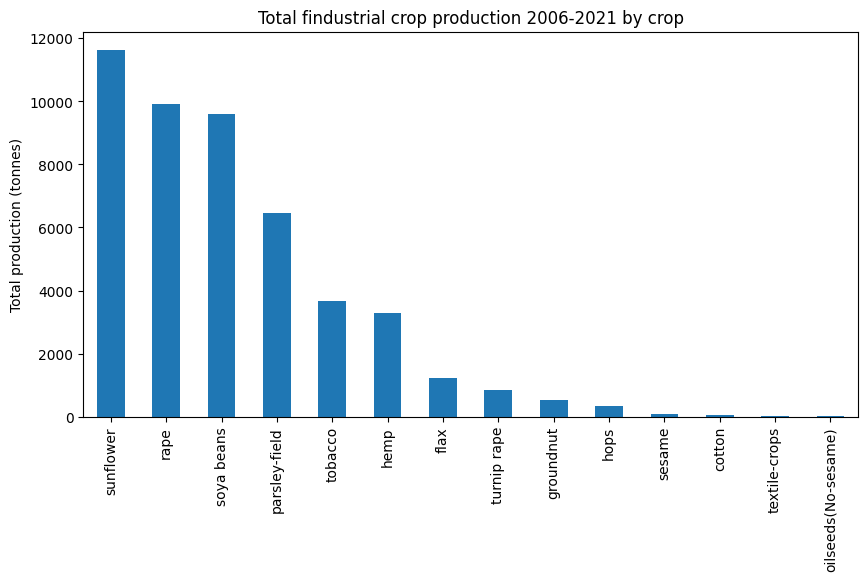

In [14]:
plt.figure(figsize=(10,5))
industrial_crop['Type_crop'].value_counts().plot.bar()
plt.title('Total findustrial crop production 2006-2021 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [15]:
industrial_crop

City      Type_crop  Year  production_tonnes  \
0                           Agrigento  parsley-field  2006               5.00   
1                           Agrigento  parsley-field  2006               5.00   
2                           Agrigento  parsley-field  2006               5.00   
3                           Agrigento  parsley-field  2006               5.00   
4                           Agrigento  parsley-field  2006               5.00   
...                               ...            ...   ...                ...   
65604  Valle d'Aosta / Vallée d'Aoste           hemp  2021               1.50   
65605  Valle d'Aosta / Vallée d'Aoste           hemp  2021               1.50   
65606  Valle d'Aosta / Vallée d'Aoste           hemp  2021               1.50   
65607  Valle d'Aosta / Vallée d'Aoste           hemp  2021               1.50   
65608  Valle d'Aosta / Vallée d'Aoste           hemp  2021               1.50   

       total_area_ha    PS    TS  QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  \
0               1.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
1               1.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
2               1.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
3               1.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
4               1.00 96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61   
...              ...   ...   ...   ...   ...   ...  ...      ...       ...   
65604           1.00 85.07  4.57  5.42 73.33  1.29  ...    -5.68      0.67   
65605           1.00 85.07  4.57  5.42 73.33  1.29  ...    -5.68      0.67   
65606           1.00 85.07  4.57  5.42 73.33  1.29  ...    -5.68      0.67   
65607           1.00 85.07  4.57  5.42 73.33  1.29  ...    -5.68      0.67   
65608           1.00 85.07  4.57  5.42 73.33  1.29  ...    -5.68      0.67   

       GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR     Type_fertilizer  \
0          0.62      39.63      21.74         1.58   calcium cyanamide   
1          0.62      39.63      21.74         1.58  nitrogen-potassium   
2          0.62      39.63      21.74         1.58         peaty-amend   
3          0.62      39.63      21.74         1.58    organic-nitrogen   
4          0.62      39.63      21.74         1.58             organic   
...         ...        ...        ...          ...                 ...   
65604      0.61      64.00      22.67         1.90  nitrogen-potassium   
65605      0.61      64.00      22.67         1.90    organic-nitrogen   
65606      0.61      64.00      22.67         1.90                urea   
65607      0.61      64.00      22.67         1.90   ammonium sulphate   
65608      0.61      64.00      22.67         1.90   calcium cyanamide   

       Fertilizers_tonnes   lat   lon  
0                    0.00 37.31 13.58  
1                   27.70 37.31 13.58  
2                  174.50 37.31 13.58  
3                  760.50 37.31 13.58  
4                 1343.70 37.31 13.58  
...                   ...   ...   ...  
65604                0.00 45.74  7.32  
65605                1.00 45.74  7.32  
65606                0.00 45.74  7.32  
65607                0.00 45.74  7.32  
65608                0.00 45.74  7.32  

[47659 rows x 22 columns]

In [16]:
industrial_crop_top10 = industrial_crop.apply(lambda row: row[industrial_crop['Type_crop'].isin(['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                                                 'soya beans', 'hemp', 'parsley-field', 
                                                                                                  'parsley-ghouse', 'tobacco', 'flax'])])

industrial_crop_top10.head()

City      Type_crop  Year  production_tonnes  total_area_ha    PS  \
0  Agrigento  parsley-field  2006               5.00           1.00 96.87   
1  Agrigento  parsley-field  2006               5.00           1.00 96.87   
2  Agrigento  parsley-field  2006               5.00           1.00 96.87   
3  Agrigento  parsley-field  2006               5.00           1.00 96.87   
4  Agrigento  parsley-field  2006               5.00           1.00 96.87   

     TS  QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  \
0 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63   
1 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63   
2 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63   
3 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63   
4 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63   

   T2M_RANGE  PRECTOTCORR     Type_fertilizer  Fertilizers_tonnes   lat   lon  
0      21.74         1.58   calcium cyanamide                0.00 37.31 13.58  
1      21.74         1.58  nitrogen-potassium               27.70 37.31 13.58  
2      21.74         1.58         peaty-amend              174.50 37.31 13.58  
3      21.74         1.58    organic-nitrogen              760.50 37.31 13.58  
4      21.74         1.58             organic             1343.70 37.31 13.58  

[5 rows x 22 columns]

In [17]:
Q1 = industrial_crop_top10.quantile(0.25)
Q3 = industrial_crop_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                    8.00
production_tonnes    1642.00
total_area_ha         575.00
PS                      3.87
TS                      3.50
QV2M                    1.05
RH2M                    4.10
WS2M                    1.01
GWETTOP                 0.12
T2M_MAX                 3.00
T2M_MIN                 4.12
GWETPROF                0.11
GWETROOT                0.11
CLOUD_AMT               9.78
T2M_RANGE               3.72
PRECTOTCORR             0.82
Fertilizers_tonnes   1907.40
lat                     3.13
lon                     3.01
dtype: float64


In [18]:
# Remove outliers
industrial_crop_top10 = industrial_crop_top10[~((industrial_crop_top10 < (Q1 - 1.5 * IQR)) | (industrial_crop_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(industrial_crop_top10.shape)

(27533, 22)


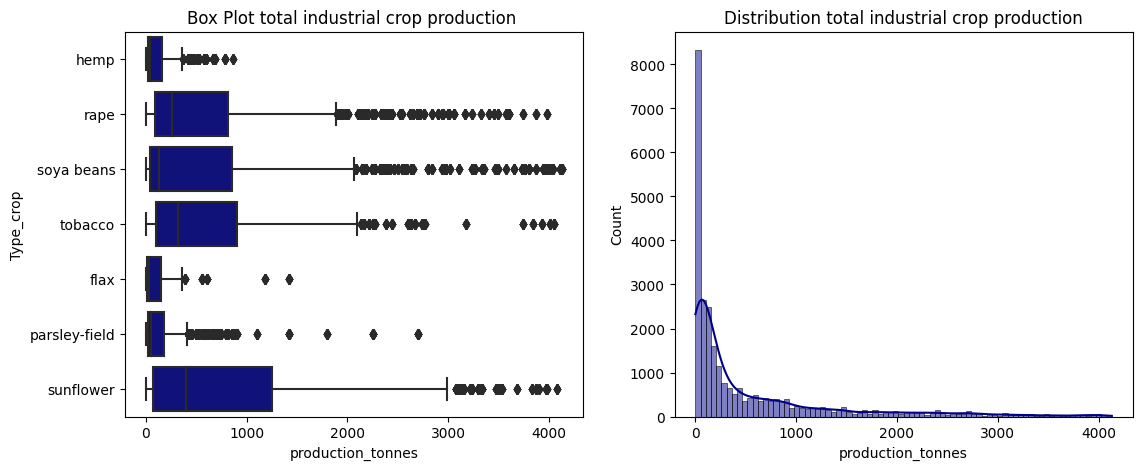

In [19]:
#Box plot and histplot (crop production distribuition)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.boxplot(data=industrial_crop_top10, x='production_tonnes', y="Type_crop",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total industrial crop production ')

plt.subplot(1,2,2)
sns.histplot(data=industrial_crop_top10, x= 'production_tonnes',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total industrial crop production')

plt.show()



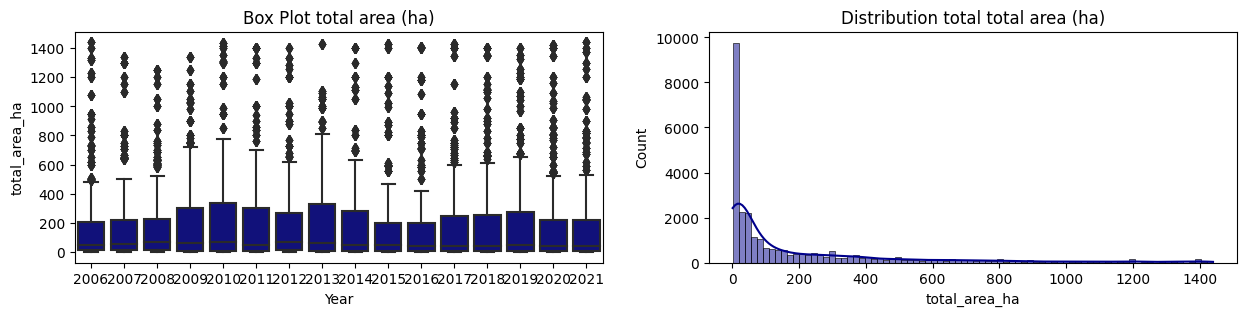

In [20]:
#Box plot and histplot of total area(ha)

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
sns.boxplot(data=industrial_crop_top10, x='Year', y="total_area_ha",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total area (ha)')

plt.subplot(1,2,2)
sns.histplot(data=industrial_crop_top10, x= 'total_area_ha',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total total area (ha)')

plt.show()

In [44]:
print(industrial_crop_top10.total_area_ha.max())
print(industrial_crop_top10.total_area_ha.min())
print(industrial_crop_top10.total_area_ha.value_counts())
print(industrial_crop_top10.total_area_ha.nunique())


1440.0
1.0


In [45]:
print(industrial_crop_top10.Fertilizers_tonnes.max())



4824.0


<AxesSubplot: xlabel='Year', ylabel='Fertilizers_tonnes'>

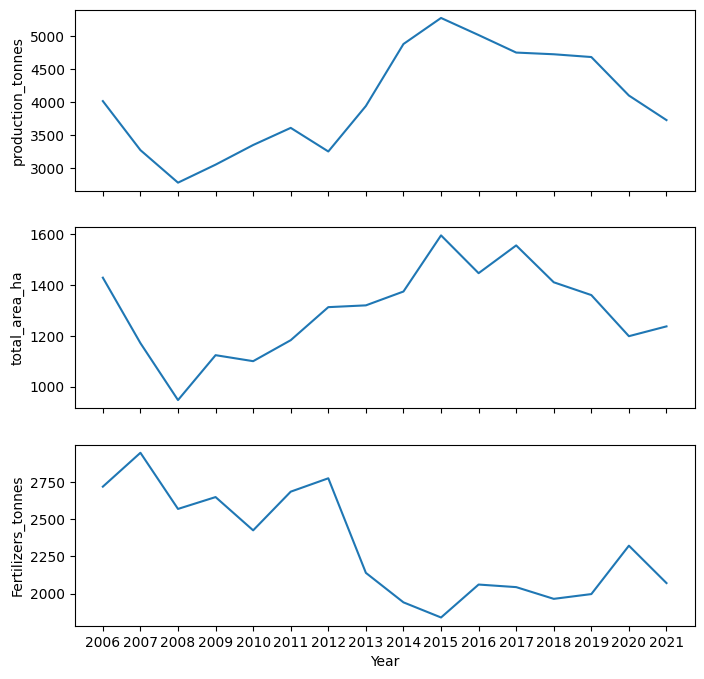

In [22]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

industrial_crop['Year'] = (industrial_crop['Year']).astype(str)

# Total crop production
crops =industrial_crop[['Year', 'production_tonnes']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="production_tonnes", ax=ax[0])

# Total area
crops =industrial_crop[['Year', 'total_area_ha']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="total_area_ha", ax=ax[1])

# Ferlizers
fertilizers =industrial_crop[['Year', 'Fertilizers_tonnes']]
fertilizers = fertilizers.groupby('Year').mean()

sns.lineplot(data= fertilizers, x="Year", y="Fertilizers_tonnes", ax=ax[2])




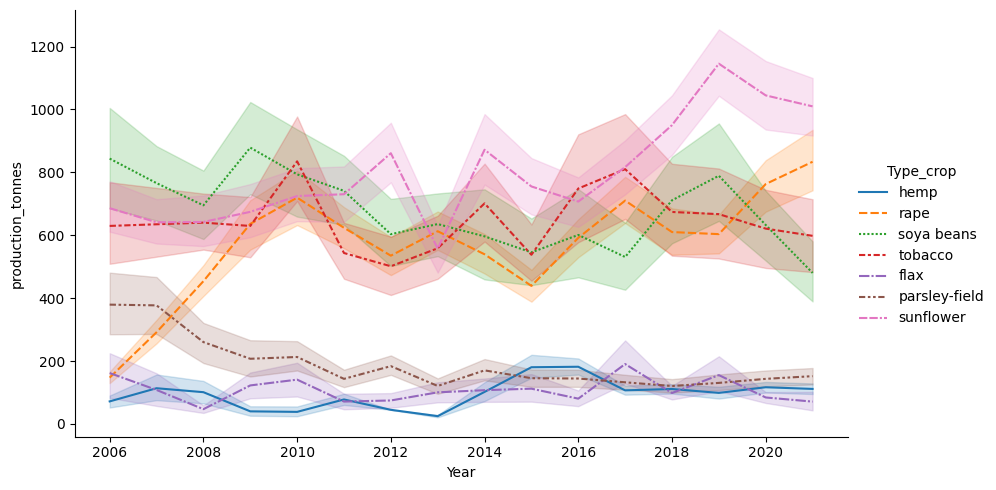

In [23]:
#Crop harvested by year

plotcrop10 = sns.relplot(kind='line', data=industrial_crop_top10, x='Year', 
                         y='production_tonnes', hue='Type_crop', style='Type_crop', aspect=1.75)


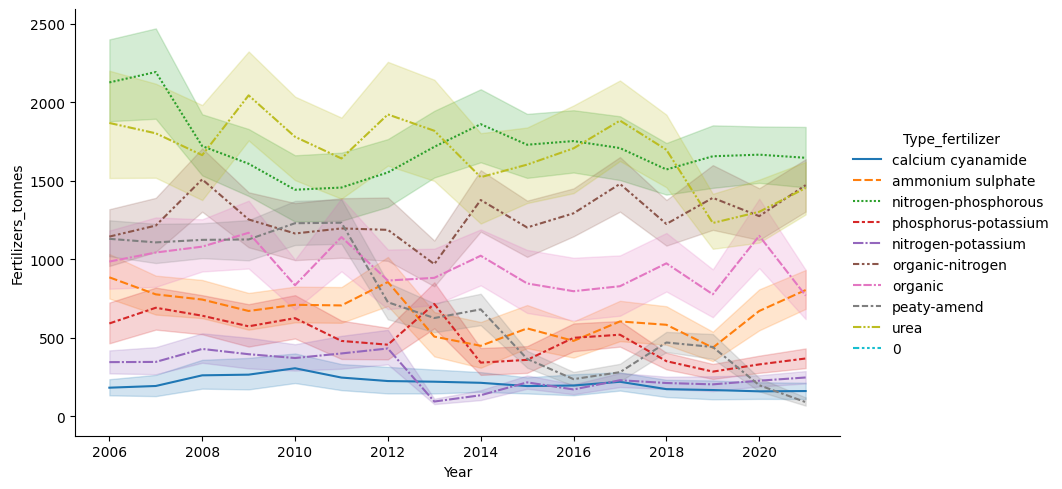

In [24]:
#Fertilizers distributed by year

plotfertilizers10 = sns.relplot(kind='line', data=industrial_crop_top10, x='Year', 
                         y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)

# Climate data analysis

|Param_Code|Param_Name|Resolution|Depth [m]|Units|
|:--------:|:--------:|:--------:|:-------:|:---:|
|GWETPROF|Profile Soil Moisture|0.5° x 0.625°|1.34 - 8.53|water-free [0], saturated soil[1]| 
|GWETTOP|Surface Soil Wetness|0.5° x 0.625°|0.00 - 0.05| water-free [0], saturated soil[1]|
|GWETROOT|Root Zone Soil Wetness|0.5° x 0.625°|0.10 - 1.00|water-free [0], saturated soil[1]|
|CLOUD_AMT|Cloud Amount|---|---|%|
|TS|Earth Skin Temperature|---|---|°C|
|PS|Surface Pressure|---|---|kPa|
|RH2M|Relative Humidity at 2 Meters|---|---|%|
|QV2M|Specific Humidity at 2 Meters|---|---|g/kg|
|PRECTOTCORR|Precipitation Corrected|---|---|mm/day|
|T2M_MAX|Temperature at 2 Meters Maximum|---|---|°C|
|T2M_MIN|Temperature at 2 Meters Minimum|---|---|°C|
|T2M_RANGE|Temperature at 2 Meters Range|---|---|°C|
|WS2M|Wind Speed at 2 Meters|---|---|m/s|


  

*Precipitation Corrected (PRECTOTCORR)- [The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow)]

*Source? https://power.larc.nasa.gov/#resources

<AxesSubplot: xlabel='Year', ylabel='GWETROOT'>

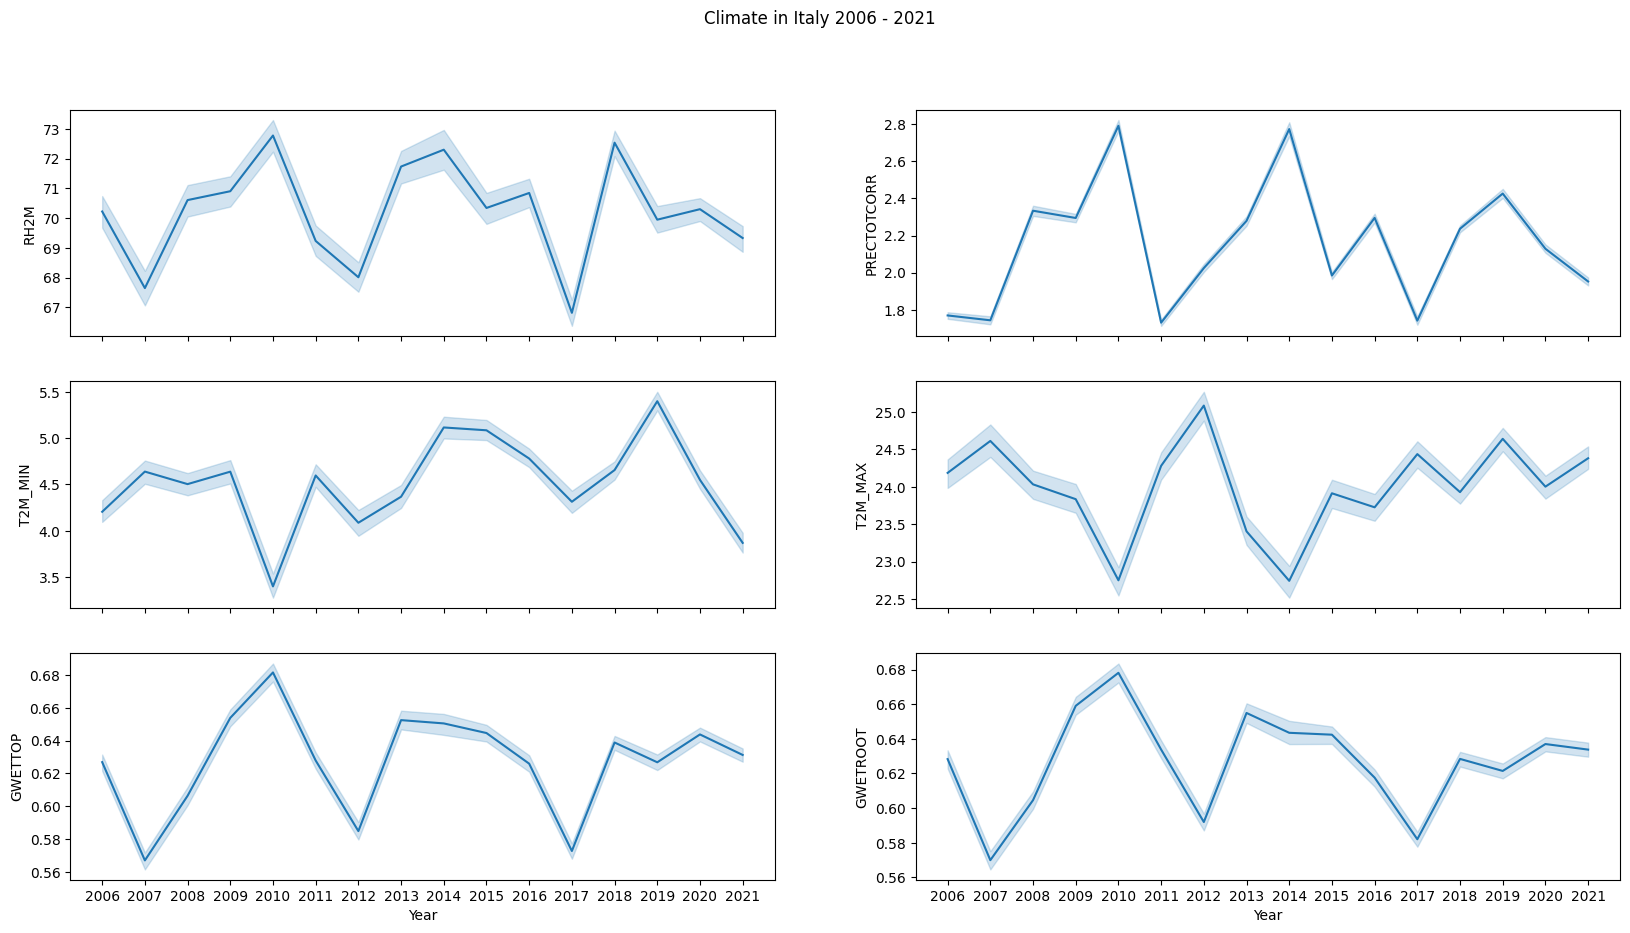

In [25]:

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(20,10))

fig.suptitle('Climate in Italy 2006 - 2021')

industrial_crop['Year'] = (industrial_crop['Year']).astype(str)

# relative_humidity
sns.lineplot(data=industrial_crop, x="Year", y="RH2M", ax=ax[0,0])

# precipitation
sns.lineplot(data=industrial_crop, x="Year", y="PRECTOTCORR", ax=ax[0,1])

# temp_max
sns.lineplot(data=industrial_crop, x="Year", y="T2M_MIN", ax=ax[1,0])

# temp_min
sns.lineplot(data=industrial_crop, x="Year", y="T2M_MAX", ax=ax[1,1])

# surface_soil_wetness
sns.lineplot(data=industrial_crop, x="Year", y="GWETTOP", ax=ax[2,0])

# root_zone_wetness
sns.lineplot(data=industrial_crop, x="Year", y="GWETROOT", ax=ax[2,1])


In [ ]:
industrial_crop

In [26]:
industrial_crop_model =industrial_crop_top10.drop(columns =['Year','PS','TS','GWETTOP', 'QV2M','WS2M','T2M_RANGE','GWETPROF','CLOUD_AMT','PRECTOTCORR','lat', 'lon'  ])
industrial_crop_model

City Type_crop  production_tonnes  total_area_ha  RH2M  T2M_MAX  \
160    Alessandria      hemp              30.00           6.00 70.99    26.42   
161    Alessandria      hemp              30.00           6.00 70.99    26.42   
163    Alessandria      hemp              30.00           6.00 70.99    26.42   
164    Alessandria      hemp              30.00           6.00 70.99    26.42   
165    Alessandria      hemp              30.00           6.00 70.99    26.42   
...            ...       ...                ...            ...   ...      ...   
65414    La Spezia   tobacco              44.70          11.00 74.70    22.91   
65415    La Spezia   tobacco              44.70          11.00 74.70    22.91   
65416    La Spezia   tobacco              44.70          11.00 74.70    22.91   
65417    La Spezia   tobacco              44.70          11.00 74.70    22.91   
65418    La Spezia   tobacco              44.70          11.00 74.70    22.91   

       T2M_MIN  GWETROOT       Type_fertilizer  Fertilizers_tonnes  
160       3.21      0.58     calcium cyanamide              196.90  
161       3.21      0.58     ammonium sulphate              147.10  
163       3.21      0.58  nitrogen-phosphorous              935.50  
164       3.21      0.58  phosphorus-potassium              592.30  
165       3.21      0.58    nitrogen-potassium             2236.50  
...        ...       ...                   ...                 ...  
65414     8.51      0.66                  urea                1.00  
65415     8.51      0.66     calcium cyanamide                0.00  
65416     8.51      0.66               organic              219.00  
65417     8.51      0.66           peaty-amend               20.00  
65418     8.51      0.66      organic-nitrogen               55.00  

[27533 rows x 10 columns]

# Pre-processing data for modelling 

In [27]:
from pycaret.regression import *

In [28]:
regr = setup(data =industrial_crop_model, target = 'production_tonnes', session_id = 123,
             categorical_features= ['City', 'Type_crop','Type_fertilizer'], normalize = True )

In [29]:
best = compare_models()

In [30]:
et = create_model('et')

# Tune model


In [ ]:
tuned_et = tune_model(et)

In [31]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

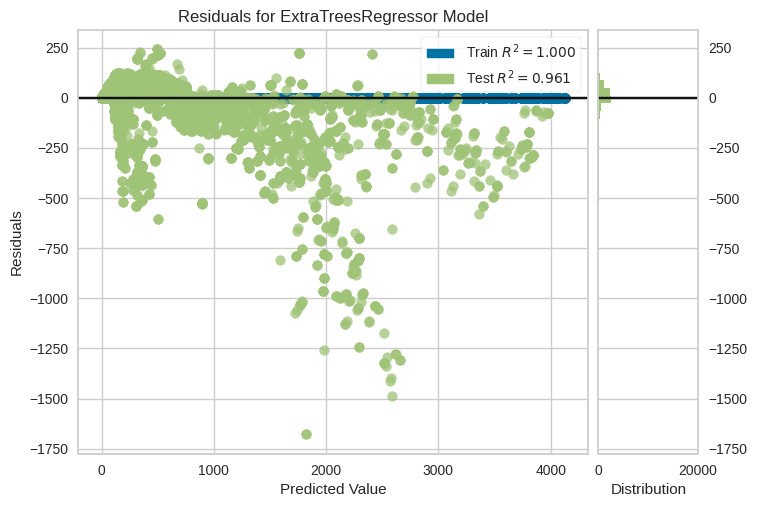

In [32]:
plot_model(et) 

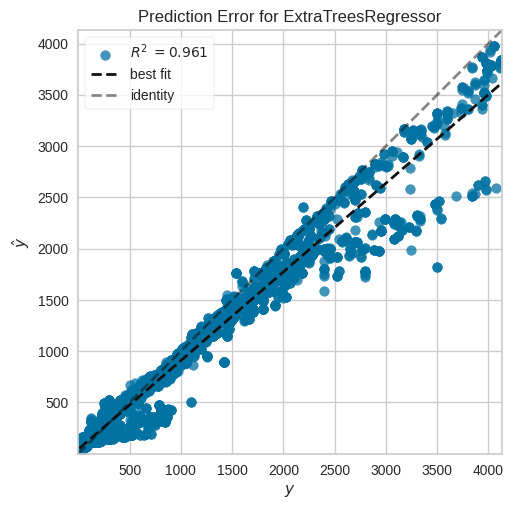

In [33]:
plot_model(et, plot = 'error')


In [34]:
plot_model(et, plot = 'parameter')


Parameters
bootstrap                         False
ccp_alpha                           0.0
criterion                 squared_error
max_depth                          None
max_features                        1.0
max_leaf_nodes                     None
max_samples                        None
min_impurity_decrease               0.0
min_samples_leaf                      1
min_samples_split                     2
min_weight_fraction_leaf            0.0
n_estimators                        100
n_jobs                               -1
oob_score                         False
random_state                        123
verbose                               0
warm_start                        False

# Predict Model

In [35]:
predictions = predict_model(et)

In [36]:
final_et = finalize_model(et)

In [37]:
print(final_et)


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                             'T2M_MIN', 'GWETROOT',
                                             'Fertilizers_tonnes'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['City', 'Type_crop',
                                             'Type_fertilizer'],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strate...
                                             'Type_fertilizer'],
                                    transformer=LeaveOneOutEncoder(cols=['City',
                                                                         'Type_crop',
                                                                        

In [39]:
save_model(final_et, 'industrial_crop_et')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                              'T2M_MIN', 'GWETROOT',
                                              'Fertilizers_tonnes'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['City', 'Type_crop',
                                              'Type_fertilizer'],
                                     transformer=SimpleImputer(fill_value='constant',
                                                               strate...
                                              'Type_fertilizer'],
                                     transformer=LeaveOneOutEncoder(cols=['City',
                                                                          'Type_crop',
                                                          

In [40]:
new_data = industrial_crop_model.copy()
new_data.drop(['production_tonnes'], axis=1, inplace=True)
predict_new = predict_model(final_et, data=new_data)
predict_new.head()


City  Type_crop  total_area_ha  RH2M  T2M_MAX  T2M_MIN  GWETROOT  \
0  1.51      -1.73          -0.63 -0.69     0.64    -0.50     -0.88   
1  1.51      -1.73          -0.63 -0.69     0.64    -0.50     -0.88   
2  1.51      -1.73          -0.63 -0.69     0.64    -0.50     -0.88   
3  1.51      -1.73          -0.63 -0.69     0.64    -0.50     -0.88   
4  1.51      -1.73          -0.63 -0.69     0.64    -0.50     -0.88   

   Type_fertilizer  Fertilizers_tonnes  prediction_label  
0             0.57               -0.54             59.98  
1             0.27               -0.59             59.98  
2            -0.70                0.13             59.98  
3             0.63               -0.18             59.98  
4             0.56                1.32             59.98

In [41]:
new_data.Type_crop.unique()

array(['hemp', 'rape', 'soya beans', 'tobacco', 'flax', 'parsley-field',
       'sunflower'], dtype=object)

In [42]:
new_data.City.unique()

array(['Alessandria', 'Ancona', 'Arezzo', 'Ascoli Piceno', 'Asti',
       'Avellino', 'Bari', 'Belluno', 'Benevento', 'Bergamo', 'Biella',
       'Bologna', 'Brescia', 'Caltanissetta', 'Campobasso', 'Caserta',
       'Catania', 'Catanzaro', 'Chieti', 'Como', 'Cosenza', 'Cremona',
       'Crotone', 'Ferrara', 'Firenze', 'Foggia', 'Frosinone', 'Genova',
       'Gorizia', 'Grosseto', 'Imperia', 'Isernia', 'Latina', 'Lecco',
       'Livorno', 'Lodi', 'Lucca', 'Macerata', 'Mantova', 'Matera',
       'Milano', 'Modena', 'Napoli', 'Novara', 'Nuoro', 'Oristano',
       'Padova', 'Parma', 'Pavia', 'Perugia', 'Pescara', 'Piacenza',
       'Pisa', 'Pistoia', 'Pordenone', 'Potenza', 'Prato', 'Ravenna',
       "Reggio nell'Emilia", 'Rieti', 'Rimini', 'Roma', 'Rovigo',
       'Salerno', 'Sassari', 'Savona', 'Siena', 'Taranto', 'Teramo',
       'Terni', 'Torino', 'Treviso', 'Trieste', 'Udine', 'Varese',
       'Venezia', 'Verbano-Cusio-Ossola', 'Vercelli', 'Verona', 'Vicenza',
       'Viterbo', 'Carb

In [43]:
new_data.Type_fertilizer.unique()

array(['calcium cyanamide', 'ammonium sulphate', 'nitrogen-phosphorous',
       'phosphorus-potassium', 'nitrogen-potassium', 'organic-nitrogen',
       'organic', 'peaty-amend', 'urea', '0'], dtype=object)

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

https://lost-stats.github.io/Presentation/Figures/heatmap_colored_correlation_matrix.html

https://plotly.com/python/box-plots/

https://pycaret.org/